# Load Libraries and Model

In [44]:
import glob

from tqdm import trange
import nibabel as nib
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

# from unetr import UNETR
# from self_attention_cv.Transformer3Dsegmentation.tranf3Dseg import Transformer3dSeg
# from self_attention_cv.transunet import TransUnet
# from self_attention_cv import TransformerEncoder
# from self_attention_cv import ViT, ResNet50ViT

In [13]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='bool')[y.astype(np.int16)]

In [14]:
def generate_brats_batch(prefix, 
                         contrasts, 
                         batch_size=32, 
                         tumour='*', 
                         patient_ids='*',
                         resample_size=(None, None, None),
                         augment_size=None,
                         infinite=True):
    """
    Generate arrays for each batch, for x (data) and y (labels), where the contrast is treated like a colour channel.
    
    Example:
    x_batch shape: (32, 240, 240, 155, 4)
    y_batch shape: (32, 240, 240, 155)
    
    augment_size must be less than or equal to the batch_size, if None will not augment.
    
    """
    file_pattern = '{prefix}/MICCAI_BraTS_2018_Data_Training/{tumour}/{patient_id}/{patient_id}_{contrast}.nii.gz'
    while True:
        n_classes = 4

        # get list of filenames for every contrast available
        keys = dict(prefix=prefix, tumour=tumour)
        filenames_by_contrast = {}
        for contrast in contrasts:
            filenames_by_contrast[contrast] = glob.glob(file_pattern.format(contrast=contrast, patient_id=patient_ids, **keys)) if patient_ids == '*' else []
            if patient_ids != '*':
                contrast_files = []
                for patient_id in patient_ids:
                    contrast_files.extend(glob.glob(file_pattern.format(contrast=contrast, patient_id=patient_id, **keys)))
                filenames_by_contrast[contrast] = contrast_files

        # get the shape of one 3D volume and initialize the batch lists
        arbitrary_contrast = contrasts[0]
        shape = nib.load(filenames_by_contrast[arbitrary_contrast][0]).get_fdata().shape if resample_size == (None, None, None) else resample_size

        # initialize empty array of batches
        x_batch = np.empty((batch_size, ) + shape + (len(contrasts), )) #, dtype=np.int32)
        y_batch = np.empty((batch_size, ) + shape + (n_classes,)) #, dtype=np.int32)
        num_images = len(filenames_by_contrast[arbitrary_contrast])
        np.random.shuffle(filenames_by_contrast[arbitrary_contrast])
        for bindex in trange(0, num_images, batch_size):
            filenames = filenames_by_contrast[arbitrary_contrast][bindex:bindex + batch_size]
            for findex, filename in enumerate(filenames):
                for cindex, contrast in enumerate(contrasts):

                    # load raw image batches and normalize the pixels
                    tmp_img = nib.load(filename.replace(arbitrary_contrast, contrast)).get_fdata()
                    if resample_size != (None, None, None):
                        tmp_img = resize(tmp_img, resample_size, mode='edge')
                    tmp_img = scalar.fit_transform(tmp_img.reshape(-1, tmp_img.shape[-1])).reshape(tmp_img.shape)
                    x_batch[findex, ..., cindex] = tmp_img

                    # load mask batches and change to categorical
                    tmp_mask = nib.load(filename.replace(arbitrary_contrast, 'seg')).get_fdata()
                    tmp_mask[tmp_mask==4] = 3
                    tmp_mask = to_categorical(tmp_mask, num_classes=4)
                    if resample_size != (None, None, None):
                        tmp_mask = resize(tmp_mask, resample_size, mode='edge')
                    y_batch[findex] = tmp_mask

            if bindex + batch_size > num_images:
                x_batch, y_batch = x_batch[:num_images - bindex], y_batch[:num_images - bindex]
            if augment_size is not None:
                # x_aug, y_aug = augment(x_batch, y_batch, augment_size)
                x_aug = None
                y_aug = None
                yield np.append(x_batch, x_aug), np.append(y_batch, y_aug)
            else:
                yield x_batch, y_batch
        if not infinite:
            break

In [20]:
prefix = '/home/atom/Documents/datasets/brats' # Adam's Station
# prefix = '/Users/Atom/Documents/datasets/brats'
trained_model = 'unet_models/model_20220419_164619_44'

In [21]:
from monai.networks.nets import BasicUNet

brats_classes = 4
brats_contrasts = 4
brats_x = 80 # 240
brats_y = 80 # 240
brats_z = 80 # 155
resampled_shape = (brats_x, brats_y, brats_z)
dropout = 0.10

model = BasicUNet(
            spatial_dims = 3,
            in_channels = brats_contrasts,
            out_channels = brats_classes,
            dropout = dropout);

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [22]:
filename = f'{prefix}/{trained_model}'
model.load_state_dict(torch.load(filename, map_location=torch.device('cpu')))

<All keys matched successfully>

In [23]:
model

BasicUNet(
  (conv_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.1, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (conv_1): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.1, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (down_1): Down(
    (max_pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): TwoConv(
      (conv_0): Convolution(
        (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (adn): ADN(
 

# Load sample data

In [24]:
test_id = 'Brats18_CBICA_APR_1' # 'Brats18_TCIA01_147_1'
tumour = 'HGG'
contrast = 'flair'
contrasts = ['t1ce', 'flair', 't2', 't1']
filename = f'{prefix}/MICCAI_BraTS_2018_Data_Training/{tumour}/{test_id}/{test_id}_{contrast}.nii.gz'

In [25]:
nii_img  = nib.load(filename)
nii_data = nii_img.get_fdata()

In [26]:
nii_data.shape

(240, 240, 155)

In [27]:
model.eval()
with torch.no_grad():
    for img, mask in generate_brats_batch(prefix, contrasts, batch_size=1, patient_ids=[test_id], infinite=False, resample_size=resampled_shape):
        # img (1, 240, 240, 155, 4) -> (1, 4, 240, 240, 155)
        img, mask = np.rollaxis(img, -1, 1), np.rollaxis(mask, -1, 1)
        
        output = torch.softmax(model(torch.FloatTensor(img)), 1)
        
        # output = torch.argmax(to_categorical_tensor(output,4), 1)
        # print("output shape ", output.shape)
        # print(f'output max {output.max()} and min {output.min()}')
        # test = to_categorical_tf(torch.argmax(output,dim=1),4)
                    
        # full_output[..., i:i+block_side, j:j+block_side, k:k+block_side] = output # np.repeat(np.repeat(np.repeat(output, patch_side, axis=-3), patch_side, axis=-2), patch_side, axis=-1)
        # print("output shape: ", full_output.shape)
                    

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


In [28]:
_, ground_truth = next(generate_brats_batch(prefix, contrasts, batch_size=1, patient_ids=[test_id], infinite=False))

  0%|                                                                                                       | 0/1 [00:01<?, ?it/s]


# Visualize

In [29]:
slice_percent = 0.60

In [31]:
from tensorflow.keras.metrics import IoU
predict_mask = output.cpu().detach().numpy()
predict_mask = np.argmax(predict_mask, axis=1)[0,:,:,:]
ground_truth_mask = np.argmax(mask, axis=1)[0,:,:,:]

n_classes = 4
iou_list = []
for i in range(n_classes):
    IOU = IoU(num_classes=n_classes, target_class_ids=[i])
    IOU.update_state(predict_mask, ground_truth_mask)
    iou_list.append(IOU.result().numpy())

print(iou_list)

[0.99806505, 0.6328461, 0.6013488, 0.4859611]


2022-04-20 01:24:02.247775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 01:24:02.248657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 01:24:02.249023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 01:24:02.249690: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [42]:
np.mean(iou_list)

0.6795553

In [43]:
np.mean(iou_list[1:])

0.57338536

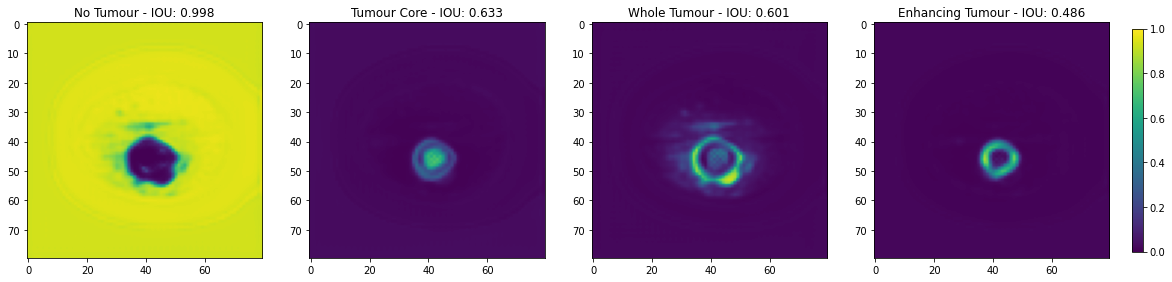

In [32]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
titles = ['No Tumour', 'Tumour Core', 'Whole Tumour', 'Enhancing Tumour']
for i in range(brats_classes):
    im = axs[i].imshow(output[0, i, :, :, int(round(slice_percent * output.shape[-1]))], vmin=0, vmax=1);
    # axs[i].set_title(f'{titles[i]}')
    axs[i].set_title(f'{titles[i]} - IOU: {iou_list[i]:.3g}')
fig.colorbar(im, ax=axs.ravel().tolist(), fraction=0.01, pad=0.02)
plt.savefig(f'../results/unet/{test_id}_predicted_probs.png')

In [77]:
unetr = np.load('../results/unetr/pred_mask.npz')['pred_mask']

Text(0.5, 1.0, 'Original Ground Truth Segmentation')

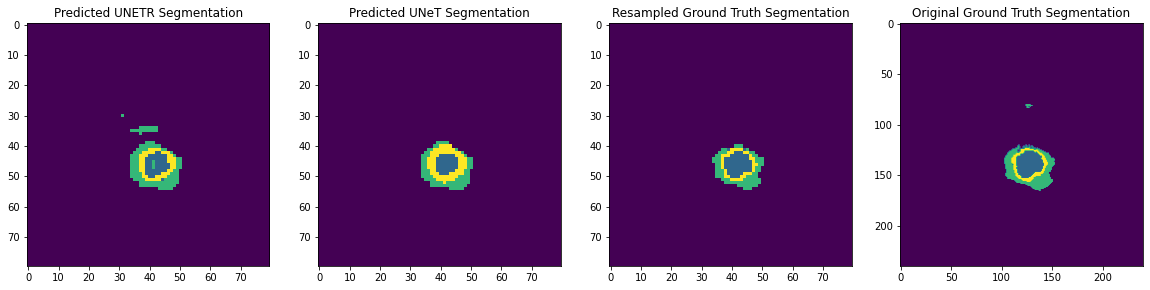

In [82]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(unetr);
axs[0].set_title('Predicted UNETR Segmentation')
axs[1].imshow(output.argmax(axis=1)[0, :, :, int(round(slice_percent * output.shape[-1]))]);
axs[1].set_title('Predicted UNeT Segmentation')
axs[2].imshow(mask.argmax(axis=1)[0, :, :, int(round(slice_percent * mask.shape[-1]))]);
axs[2].set_title('Resampled Ground Truth Segmentation')
axs[3].imshow(ground_truth.argmax(axis=-1)[0, :, :, int(round(slice_percent * ground_truth.shape[-2]))]);
axs[3].set_title('Original Ground Truth Segmentation')
# add legend
# plt.savefig(f'../results/unet/{test_id}_predicted_vs_gt.png')

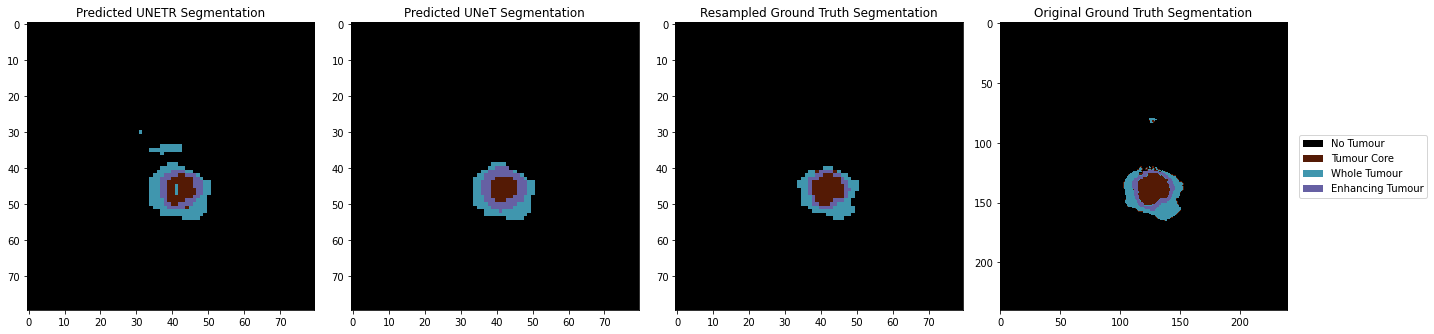

In [85]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
colors = [(0, 0, 0), (84/255, 26/255, 5/255), (64/255, 150/255, 174/255), (102/255, 96/255, 163/255)]
titles = ['No Tumour', 'Tumour Core', 'Whole Tumour', 'Enhancing Tumour']
cmap = LinearSegmentedColormap.from_list('nepari_labels', colors, N=4)
axs[0].imshow(unetr, cmap=cmap);
axs[0].set_title('Predicted UNETR Segmentation')
axs[1].imshow(output.argmax(axis=1)[0, :, :, int(round(slice_percent * output.shape[-1]))], cmap=cmap);
axs[1].set_title('Predicted UNeT Segmentation')
axs[2].imshow(mask.argmax(axis=1)[0, :, :, int(round(slice_percent * mask.shape[-1]))], cmap=cmap);
axs[2].set_title('Resampled Ground Truth Segmentation')
axs[3].imshow(ground_truth.argmax(axis=-1)[0, :, :, int(round(slice_percent * ground_truth.shape[-2]))], cmap=cmap);
axs[3].set_title('Original Ground Truth Segmentation')

legend_elements = [Patch(facecolor=color, label=title) for color, title in zip(colors, titles)]
axs[3].legend(handles=legend_elements, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.tight_layout()
plt.savefig(f'../results/gt/{test_id}_gt.png')

In [30]:
ground_truth.shape

(1, 240, 240, 155, 4)

In [31]:
import napari
viewer = napari.view_image(output[0, 1].detach().numpy(), name="tumour core prediction probabilities")
for i in range(len(contrasts)):
    viewer.add_image(img[0, i, ...], name=test_id + '' + contrasts[i])

gt_layer = viewer.add_labels(mask.argmax(axis=1)[0], name="ground truth")
pred_layer = viewer.add_labels(output.argmax(axis=1)[0].detach().numpy(), name="predicted classes")

In [3]:
# try to quantify attention of the UNETR